<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 565, '日付': '2021-09-19T08:00:00.000Z'},
 {'小計': 302, '日付': '2021-09-20T08:00:00.000Z'},
 {'小計': 253, '日付': '2021-09-21T08:00:00.000Z'},
 {'小計': 537, '日付': '2021-09-22T08:00:00.000Z'},
 {'小計': 531, '日付': '2021-09-23T08:00:00.000Z'},
 {'小計': 235, '日付': '2021-09-24T08:00:00.000Z'},
 {'小計': 382, '日付': '2021-09-25T08:00:00.000Z'},
 {'小計': 299, '日付': '2021-09-26T08:00:00.000Z'},
 {'小計': 154, '日付': '2021-09-27T08:00:00.000Z'},
 {'小計': 248, '日付': '2021-09-28T08:00:00.000Z'},
 {'小計': 267, '日付': '2021-09-29T08:00:00.000Z'},
 {'小計': 218, '日付': '2021-09-30T08:00:00.000Z'},
 {'小計': 200, '日付': '2021-10-01T08:00:00.000Z'},
 {'小計': 196, '日付': '2021-10-02T08:00:00.000Z'},
 {'小計': 161, '日付': '2021-10-03T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-09-29 17:00:00+09:00,209,0,267,2021-09-29 17:00:00+09:00
2021-09-30 17:00:00+09:00,211,0,218,2021-09-30 17:00:00+09:00
2021-10-01 17:00:00+09:00,0,0,200,2021-10-01 17:00:00+09:00
2021-10-02 17:00:00+09:00,0,0,196,2021-10-02 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-09-29 17:00:00+09:00,209,0,267,2021-09-29 17:00:00+09:00,226.142857,1583.0,0.0,0.0,302.285714,2116.0
2021-09-30 17:00:00+09:00,211,0,218,2021-09-30 17:00:00+09:00,214.142857,1499.0,0.0,0.0,257.571429,1803.0
2021-10-01 17:00:00+09:00,0,0,200,2021-10-01 17:00:00+09:00,181.857143,1273.0,0.0,0.0,252.571429,1768.0
2021-10-02 17:00:00+09:00,0,0,196,2021-10-02 17:00:00+09:00,151.000000,1057.0,0.0,0.0,226.000000,1582.0
2021-10-03 17:00:00+09:00,0,0,161,2021-10-03 17:00:00+09:00,124.571429,872.0,0.0,0.0,206.285714,1444.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-09-19 17:00:00+09:00,255,0,565,2021-09-19 17:00:00+09:00,365.857143,2561.0,0.0,0.0,815.285714,5707.0,'21w37,Sun
2021-09-20 17:00:00+09:00,306,0,302,2021-09-20 17:00:00+09:00,344.571429,2412.0,0.0,0.0,771.142857,5398.0,'21w38,Mon
2021-09-21 17:00:00+09:00,312,0,253,2021-09-21 17:00:00+09:00,324.142857,2269.0,0.0,0.0,663.857143,4647.0,'21w38,Tue
2021-09-22 17:00:00+09:00,264,0,537,2021-09-22 17:00:00+09:00,308.428571,2159.0,0.0,0.0,590.285714,4132.0,'21w38,Wed
2021-09-23 17:00:00+09:00,295,0,531,2021-09-23 17:00:00+09:00,303.857143,2127.0,0.0,0.0,547.428571,3832.0,'21w38,Thu
2021-09-24 17:00:00+09:00,226,0,235,2021-09-24 17:00:00+09:00,287.571429,2013.0,0.0,0.0,469.285714,3285.0,'21w38,Fri
2021-09-25 17:00:00+09:00,216,0,382,2021-09-25 17:00:00+09:00,267.714286,1874.0,0.0,0.0,400.714286,2805.0,'21w38,Sat
2021-09-26 17:00:00+09:00,185,0,299,2021-09-26 17:00:00+09:00,257.714286,1804.0,0.0,0.0,362.714286,2539.0,'21w38,Sun
2021-09-27 17:00:00+09:00,222,0,154,2021-09-27 17:00:00+09:00,245.714286,1720.0,0.0,0.0,341.571429,2391.0,'21w39,Mon
2021-09-28 17:00:00+09:00,230,0,248,2021-09-28 17:00:00+09:00,234.000000,1638.0,0.0,0.0,340.857143,2386.0,'21w39,Tue


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-09-12 17:00:00+09:00,1384.000000,9688
2021-09-19 17:00:00+09:00,815.285714,5707
2021-09-26 17:00:00+09:00,362.714286,2539
2021-10-03 17:00:00+09:00,206.285714,1444
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-09-19 17:00:00+09:00,255,0,565,2021-09-19 17:00:00+09:00,365.857143,2561.0,0.0,0.0,815.285714,5707.0,'21w37,Sun,815.285714,5707.0
2021-09-20 17:00:00+09:00,306,0,302,2021-09-20 17:00:00+09:00,344.571429,2412.0,0.0,0.0,771.142857,5398.0,'21w38,Mon,NaN,NaN
2021-09-21 17:00:00+09:00,312,0,253,2021-09-21 17:00:00+09:00,324.142857,2269.0,0.0,0.0,663.857143,4647.0,'21w38,Tue,NaN,NaN
2021-09-22 17:00:00+09:00,264,0,537,2021-09-22 17:00:00+09:00,308.428571,2159.0,0.0,0.0,590.285714,4132.0,'21w38,Wed,NaN,NaN
2021-09-23 17:00:00+09:00,295,0,531,2021-09-23 17:00:00+09:00,303.857143,2127.0,0.0,0.0,547.428571,3832.0,'21w38,Thu,NaN,NaN
2021-09-24 17:00:00+09:00,226,0,235,2021-09-24 17:00:00+09:00,287.571429,2013.0,0.0,0.0,469.285714,3285.0,'21w38,Fri,NaN,NaN
2021-09-25 17:00:00+09:00,216,0,382,2021-09-25 17:00:00+09:00,267.714286,1874.0,0.0,0.0,400.714286,2805.0,'21w38,Sat,NaN,NaN
2021-09-26 17:00:00+09:00,185,0,299,2021-09-26 17:00:00+09:00,257.714286,1804.0,0.0,0.0,362.714286,2539.0,'21w38,Sun,362.714286,2539.0
2021-09-27 17:00:00+09:00,222,0,154,2021-09-27 17:00:00+09:00,245.714286,1720.0,0.0,0.0,341.571429,2391.0,'21w39,Mon,NaN,NaN
2021-09-28 17:00:00+09:00,230,0,248,2021-09-28 17:00:00+09:00,234.000000,1638.0,0.0,0.0,340.857143,2386.0,'21w39,Tue,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

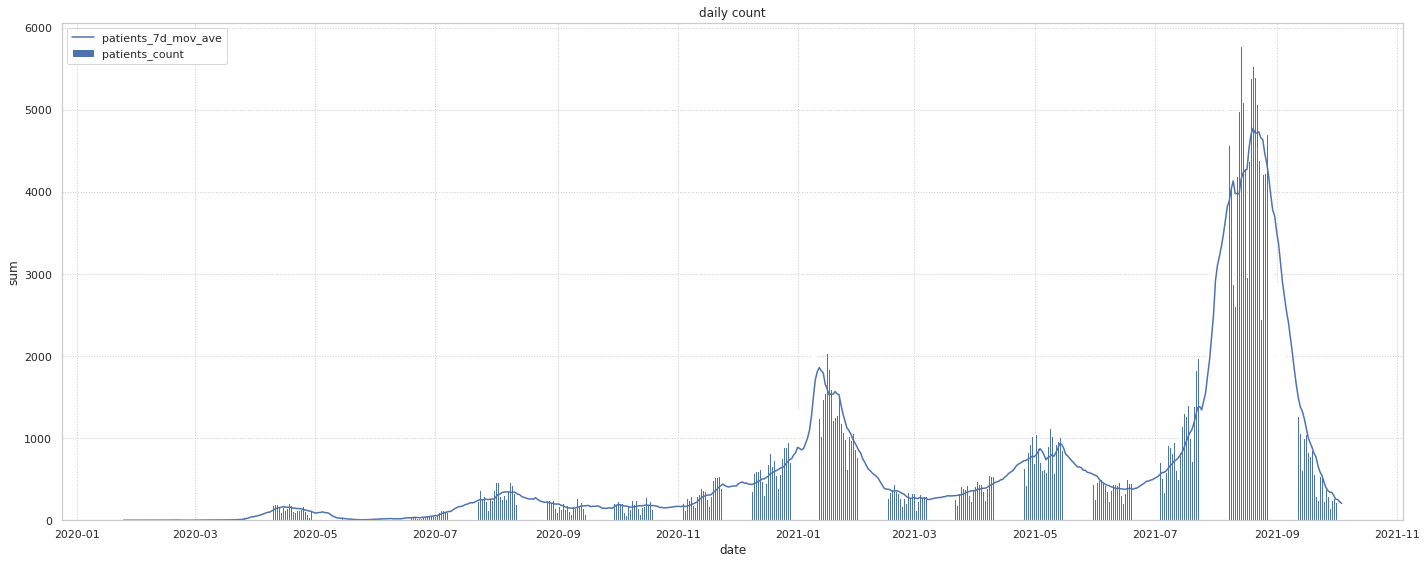

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
604,1.632038e+09,2021,9,19,0,0,0,1,0,0,0,604,0,530,255,365.857143,2561.0,0,0.0,0.0,565,815.285714,5707.0
605,1.632125e+09,2021,9,20,0,1,0,0,0,0,0,605,0,531,306,344.571429,2412.0,0,0.0,0.0,302,771.142857,5398.0
606,1.632211e+09,2021,9,21,0,0,0,0,0,1,0,606,0,532,312,324.142857,2269.0,0,0.0,0.0,253,663.857143,4647.0
607,1.632298e+09,2021,9,22,0,0,0,0,0,0,1,607,0,533,264,308.428571,2159.0,0,0.0,0.0,537,590.285714,4132.0
608,1.632384e+09,2021,9,23,0,0,0,0,1,0,0,608,0,534,295,303.857143,2127.0,0,0.0,0.0,531,547.428571,3832.0
609,1.632470e+09,2021,9,24,1,0,0,0,0,0,0,609,0,535,226,287.571429,2013.0,0,0.0,0.0,235,469.285714,3285.0
610,1.632557e+09,2021,9,25,0,0,1,0,0,0,0,610,0,536,216,267.714286,1874.0,0,0.0,0.0,382,400.714286,2805.0
611,1.632643e+09,2021,9,26,0,0,0,1,0,0,0,611,0,537,185,257.714286,1804.0,0,0.0,0.0,299,362.714286,2539.0
612,1.632730e+09,2021,9,27,0,1,0,0,0,0,0,612,0,538,222,245.714286,1720.0,0,0.0,0.0,154,341.571429,2391.0
613,1.632816e+09,2021,9,28,0,0,0,0,0,1,0,613,0,539,230,234.000000,1638.0,0,0.0,0.0,248,340.857143,2386.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            619 non-null    float64
 1   year                 619 non-null    int64  
 2   month                619 non-null    int64  
 3   day                  619 non-null    int64  
 4   Fri                  619 non-null    uint8  
 5   Mon                  619 non-null    uint8  
 6   Sat                  619 non-null    uint8  
 7   Sun                  619 non-null    uint8  
 8   Thu                  619 non-null    uint8  
 9   Tue                  619 non-null    uint8  
 10  Wed                  619 non-null    uint8  
 11  passed               619 non-null    int64  
 12  emergency            619 non-null    int64  
 13  em_passed            619 non-null    int64  
 14  contacts_count       619 non-null    int64  
 15  contacts_7d_mov_ave  619 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,6.190000e+02,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000
mean,1.606550e+09,2020.445880,6.075929,15.796446,0.143780,0.142165,0.143780,0.143780,0.142165,0.142165,0.142165,309.000000,0.079160,239.483037,689.903069,689.608316,4827.252019,595.345719,595.345719,4167.420032,607.387722,606.426333,4244.957997
std,1.545127e+07,0.497464,3.116776,8.875109,0.351151,0.349501,0.351151,0.351151,0.349501,0.349501,0.349501,178.834188,0.270207,172.128097,464.824246,451.849793,3162.957972,834.324305,759.126331,5313.884317,976.129295,942.123120,6594.878800
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.593202e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.500000,0.000000,80.500000,374.000000,379.500000,2656.500000,0.000000,0.000000,0.000000,106.500000,139.357143,975.500000
50%,1.606550e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,309.000000,0.000000,235.000000,529.000000,550.000000,3850.000000,0.000000,0.000000,0.000000,290.000000,297.000000,2079.000000
75%,1.619899e+09,2021.000000,8.500000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,463.500000,0.000000,389.500000,825.500000,832.785714,5829.500000,1223.000000,1201.714286,8412.000000,614.000000,632.000000,4424.000000
max,1.633248e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,618.000000,1.000000,544.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5773.000000,4774.428571,33421.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.860939,0.235830,0.008793,-0.002293,-0.003417,2.360875e-18,0.002293,0.003417,-0.001139,0.001139,1.000000e+00,-0.346213,0.997435,-0.107437,-0.086009,-0.086006,-0.598703,-0.644833,-0.644833,0.571127,0.600780,0.600785
year,8.609385e-01,1.000000,-0.289038,-0.026688,0.002933,-0.002210,2.933064e-03,0.002933,-0.002210,-0.002210,-0.002210,8.609385e-01,-0.263007,0.871099,-0.142778,-0.121551,-0.121549,-0.640609,-0.704067,-0.704067,0.493251,0.519893,0.519895
month,2.358298e-01,-0.289038,1.000000,-0.025705,-0.009991,-0.002498,-5.555609e-03,-0.001120,0.010871,0.001958,0.006415,2.358298e-01,-0.147408,0.211385,0.073132,0.072996,0.072999,0.098678,0.134433,0.134433,0.131347,0.136304,0.136310
day,8.793189e-03,-0.026688,-0.025705,1.000000,0.000580,0.003606,-9.780304e-04,-0.002016,-0.002132,0.001519,-0.000567,8.793189e-03,-0.003391,0.009889,-0.011528,-0.014460,-0.014463,0.002952,-0.009745,-0.009745,0.007950,0.004916,0.004912
Fri,-2.293283e-03,0.002933,-0.009991,0.000580,1.000000,-0.166821,-1.679245e-01,-0.167925,-0.166821,-0.166821,-0.166821,-2.293283e-03,-0.000771,-0.001579,-0.019563,-0.003753,-0.003752,0.028257,-0.002065,-0.002065,0.029771,-0.001524,-0.001527
Mon,-3.417322e-03,-0.002210,-0.002498,0.003606,-0.166821,1.000000,-1.668212e-01,-0.166821,-0.165725,-0.165725,-0.165725,-3.417322e-03,0.000581,-0.003510,0.038940,0.002344,0.002345,0.121136,0.001556,0.001556,-0.095923,0.000790,0.000791
Sat,2.360875e-18,0.002933,-0.005556,-0.000978,-0.167925,-0.166821,1.000000e+00,-0.167925,-0.166821,-0.166821,-0.166821,4.577178e-18,-0.000771,0.000509,0.045589,-0.003753,-0.003752,-0.139424,-0.002065,-0.002065,0.030711,-0.001388,-0.001390
Sun,2.293283e-03,0.002933,-0.001120,-0.002016,-0.167925,-0.166821,-1.679245e-01,1.000000,-0.166821,-0.166821,-0.166821,2.293283e-03,-0.000771,0.002597,-0.028634,-0.003753,-0.003752,-0.128604,-0.002065,-0.002065,-0.024182,-0.001277,-0.001277
Thu,3.417322e-03,-0.002210,0.010871,-0.002132,-0.166821,-0.165725,-1.668212e-01,-0.166821,1.000000,-0.165725,-0.165725,3.417322e-03,0.000581,0.002757,-0.004347,0.003295,0.003296,0.036345,0.001556,0.001556,0.056190,0.001304,0.001306
Tue,-1.139107e-03,-0.002210,0.001958,0.001519,-0.166821,-0.165725,-1.668212e-01,-0.166821,-0.165725,1.000000,-0.165725,-1.139107e-03,0.000581,-0.001439,-0.020294,0.002681,0.002681,0.049180,0.001556,0.001556,-0.019841,0.000964,0.000965


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,1.632902e+09,0,0,0,0,0,0,1,614,0,540,209,0,267,302.285714,2116.0
615,1.632989e+09,0,0,0,0,1,0,0,615,0,541,211,0,218,257.571429,1803.0
616,1.633075e+09,1,0,0,0,0,0,0,616,0,542,0,0,200,252.571429,1768.0
617,1.633162e+09,0,0,1,0,0,0,0,617,0,543,0,0,196,226.000000,1582.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
614,1.632902e+09,614,0,267,302.285714,2116.0
615,1.632989e+09,615,0,218,257.571429,1803.0
616,1.633075e+09,616,0,200,252.571429,1768.0
617,1.633162e+09,617,0,196,226.000000,1582.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

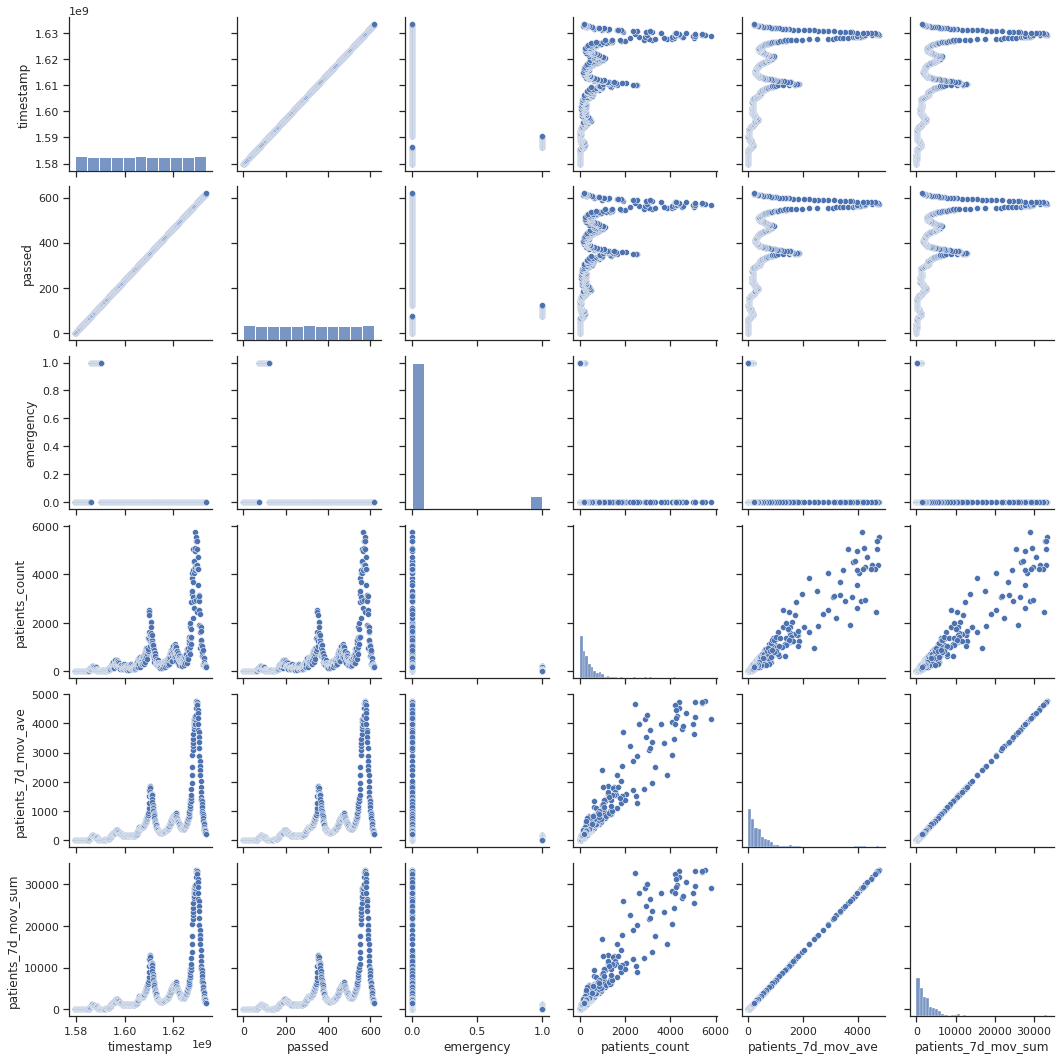

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
